Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (Text  (None, 498)               1         
 Vectorization)                                                  
                                                                 
 dense_7 (Dense)             (None, 512)               255488    
                                                                 
 dense_8 (Dense)             (None, 256)               131328    
                                                                 
 dense_9 (Dense)             (None, 152)               39064     
                                                                 
Total params: 425881 (1.62 MB)
Trainable params: 425880 (1.62 MB)
Non-trainable params: 1 (8.00 Byte)
_________________________________________________________________
Epoch 1/20
258/258 [==============================] - 7s 12ms/step - loss: 0.0429 - 

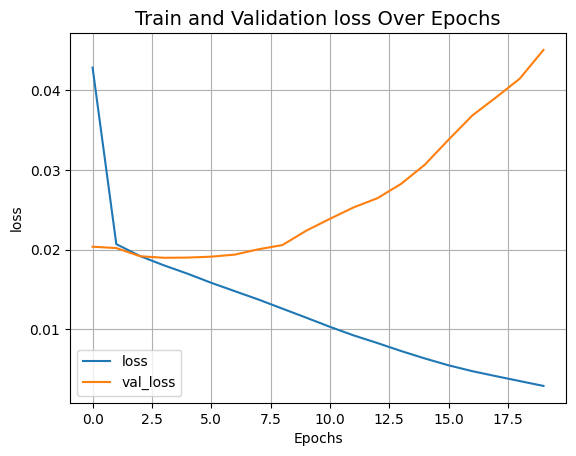

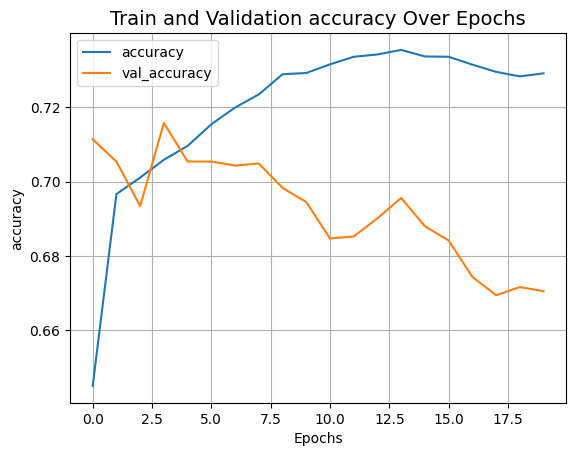

15/15 [==============================] - 0s 9ms/step - loss: 0.0458 - accuracy: 0.6568
Accuracy on the test set: 65.68%.


In [ ]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from ast import literal_eval
import pandas as pd
import numpy as np

arxiv_data = pd.read_csv("/content/drive/MyDrive/IML-Recommender-Paper/arxiv_data.csv")

# Remove duplicate titles
arxiv_data = arxiv_data[~arxiv_data["titles"].duplicated()]

# Filter out rare terms
arxiv_data_filtered = arxiv_data.groupby("terms").filter(lambda x: len(x) > 1)

# Convert string representation of lists to actual lists
arxiv_data_filtered["terms"] = arxiv_data_filtered["terms"].apply(lambda x: literal_eval(x))

test_split = 0.1

# Initial train and test split
train_df, test_df = train_test_split(
    arxiv_data_filtered,
    test_size=test_split,
    stratify=arxiv_data_filtered["terms"].values
)

# Further split the test set into validation and new test sets
val_df = test_df.sample(frac=0.5)
test_df.drop(val_df.index, inplace=True)

mlb = MultiLabelBinarizer()
mlb.fit_transform(train_df["terms"])

train_dataset = tf.data.Dataset.from_tensor_slices(
    (train_df["summaries"].values, mlb.transform(train_df["terms"].values))
)
train_dataset = train_dataset.shuffle(len(train_df)).batch(batch_size)

validation_dataset = tf.data.Dataset.from_tensor_slices(
    (val_df["summaries"].values, mlb.transform(val_df["terms"].values))
)
validation_dataset = validation_dataset.batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices(
    (test_df["summaries"].values, mlb.transform(test_df["terms"].values))
)
test_dataset = test_dataset.batch(batch_size)

# Define the TextVectorization layer
text_vectorizer = layers.TextVectorization(max_tokens=vocabulary_size, output_mode="tf_idf")

# Adapt the TextVectorization layer to the training dataset
text_vectorizer.adapt(train_dataset.map(lambda text, label: text))

def make_model():
    shallow_mlp_model = keras.Sequential([
        text_vectorizer,
        layers.Dense(512, activation="relu"),
        layers.Dense(256, activation="relu"),
        layers.Dense(len(mlb.classes_), activation="sigmoid")
    ])
    return shallow_mlp_model

shallow_mlp_model = make_model()
shallow_mlp_model.summary()

epochs = 20

shallow_mlp_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

history = shallow_mlp_model.fit(train_dataset, validation_data=validation_dataset, epochs=epochs)

def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()

plot_result("loss")
plot_result("accuracy")

test_loss, test_accuracy = shallow_mlp_model.evaluate(test_dataset)
print(f"Accuracy on the test set: {test_accuracy * 100:.2f}%.")


In [ ]:
text_batch, label_batch = next(iter(test_dataset))
predicted_probabilities = shallow_mlp_model.predict(text_batch)

for i, text_tensor in enumerate(text_batch[:5]):
    # Convert the text tensor to a string
    text = text_tensor.numpy().decode("utf-8")
    label = label_batch[i].numpy()[None, ...]
    print(f"Label(s): {mlb.inverse_transform(label)[0]}")
    predicted_proba = predicted_probabilities[i]
    top_3_indices = np.argsort(predicted_proba)[::-1][:3]  # Indices of top 3 predicted labels
    top_3_labels = mlb.classes_[top_3_indices]  # Get corresponding labels
    print(f"Predicted Label(s): {', '.join(top_3_labels)}")
    print(" ")


4/4 [==============================] - 0s 8ms/step
Label(s): ('cs.LG', 'stat.ML')
Predicted Label(s): cs.LG, stat.ML, eess.IV
 
Label(s): ('cs.CV', 'cs.LG', 'eess.IV')
Predicted Label(s): cs.CV, cs.LG, eess.IV
 
Label(s): ('cs.CV',)
Predicted Label(s): cs.LG, stat.ML, cs.CV
 
Label(s): ('cs.CV',)
Predicted Label(s): cs.CV, eess.IV, cs.GR
 
Label(s): ('cs.LG', 'math.ST', 'stat.ME', 'stat.ML', 'stat.TH')
Predicted Label(s): cs.LG, stat.ML, math.OC
 
